 # Feature Engineering

 ## Merge Sales and Prices and Calendar Data

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import lightgbm as lgb
import xgboost as xgb

# import datetime module
import datetime as dt

In [30]:
sampled_df_subset = pd.read_csv("../datasets/long_train_subset.csv")

sampled_df_subset.head()

,id,day_number,category_id,store_id,item_id,subcat_id,region_id,units_sold,date,wm_yr_wk,weekday,wday,month,year,sell_price
0,Food_2_374_East_4,1119,Food,East_4,Food_2_374,Food_2,East,1,2014-02-20,11403.0,Thursday,6.0,2.0,2014.0,2.00
1,Food_3_310_East_1,1583,Food,East_1,Food_3_310,Food_3,East,2,2015-05-30,11518.0,Saturday,1.0,5.0,2015.0,1.00
2,Beauty_2_030_West_2,1108,Beauty,West_2,Beauty_2_030,Beauty_2,West,0,2014-02-09,11402.0,Sunday,2.0,2.0,2014.0,0.97
3,Food_3_067_West_2,1210,Food,West_2,Food_3_067,Food_3,West,0,2014-05-22,11416.0,Thursday,6.0,5.0,2014.0,3.98
4,Food_2_155_East_1,1290,Food,East_1,Food_2_155,Food_2,East,0,2014-08-10,11428.0,Sunday,2.0,8.0,2014.0,2.50


In [31]:
sampled_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462105 entries, 0 to 462104
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           462105 non-null  object 
 1   day_number   462105 non-null  int64  
 2   category_id  462105 non-null  object 
 3   store_id     462105 non-null  object 
 4   item_id      462105 non-null  object 
 5   subcat_id    462105 non-null  object 
 6   region_id    462105 non-null  object 
 7   units_sold   462105 non-null  int64  
 8   date         462105 non-null  object 
 9   wm_yr_wk     462105 non-null  float64
 10  weekday      462105 non-null  object 
 11  wday         462105 non-null  float64
 12  month        462105 non-null  float64
 13  year         462105 non-null  float64
 14  sell_price   462105 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 52.9+ MB


In [32]:
sampled_df_subset["id"] = sampled_df_subset["id"].astype("string")
sampled_df_subset["category_id"] = sampled_df_subset["category_id"].astype("string")
sampled_df_subset["store_id"] = sampled_df_subset["store_id"].astype("string")
sampled_df_subset["item_id"] = sampled_df_subset["item_id"].astype("string")
sampled_df_subset["subcat_id"] = sampled_df_subset["subcat_id"].astype("string")
sampled_df_subset["region_id"] = sampled_df_subset["region_id"].astype("string")
sampled_df_subset["date"] = pd.to_datetime(sampled_df_subset["date"])
sampled_df_subset["wm_yr_wk"] = sampled_df_subset["wm_yr_wk"].astype(int)
sampled_df_subset["weekday"] = sampled_df_subset["weekday"].astype("string")
sampled_df_subset["wday"] = sampled_df_subset["wday"].astype(int)
sampled_df_subset["month"] = sampled_df_subset["month"].astype(int)
sampled_df_subset["year"] = sampled_df_subset["year"].astype(int)

In [33]:
sampled_df_subset['day_of_week'] = sampled_df_subset['date'].dt.dayofweek + 1
sampled_df_subset['day_of_month'] = sampled_df_subset['date'].dt.day
sampled_df_subset['day_of_year'] = sampled_df_subset['date'].dt.dayofyear
sampled_df_subset['week_of_month'] = (sampled_df_subset['date'].dt.day - 1) // 7 + 1
sampled_df_subset['month_of_year'] = sampled_df_subset['date'].dt.month

In [34]:
# Without using isocalendar as that is in newer version of pandas
sampled_df_subset['week_of_year'] = pd.to_datetime(sampled_df_subset['date']).dt.strftime('%U').astype(int)

In [35]:
# Assign date to index
# sampled_df_subset = sampled_df_subset.set_index("date") 
sampled_df_subset.head()

,id,day_number,category_id,store_id,item_id,subcat_id,region_id,units_sold,date,wm_yr_wk,...,wday,month,year,sell_price,day_of_week,day_of_month,day_of_year,week_of_month,month_of_year,week_of_year
0,Food_2_374_East_4,1119,Food,East_4,Food_2_374,Food_2,East,1,2014-02-20,11403,...,6,2,2014,2.00,4,20,51,3,2,7
1,Food_3_310_East_1,1583,Food,East_1,Food_3_310,Food_3,East,2,2015-05-30,11518,...,1,5,2015,1.00,6,30,150,5,5,21
2,Beauty_2_030_West_2,1108,Beauty,West_2,Beauty_2_030,Beauty_2,West,0,2014-02-09,11402,...,2,2,2014,0.97,7,9,40,2,2,6
3,Food_3_067_West_2,1210,Food,West_2,Food_3_067,Food_3,West,0,2014-05-22,11416,...,6,5,2014,3.98,4,22,142,4,5,20
4,Food_2_155_East_1,1290,Food,East_1,Food_2_155,Food_2,East,0,2014-08-10,11428,...,2,8,2014,2.50,7,10,222,2,8,32


 # Correlation of price on sales

In [36]:
corr = sampled_df_subset[['sell_price', 'units_sold']].corr()
print('Correlation between sales and price:', corr.iloc[0,1])

Correlation between sales and price: -0.15028565910853842


 There is a negative correlation between units sold and price, which is no surprised at all, given the basic concept that people buy less items if the price is higher.

 Scatterplot to see if this relationship is linear or not

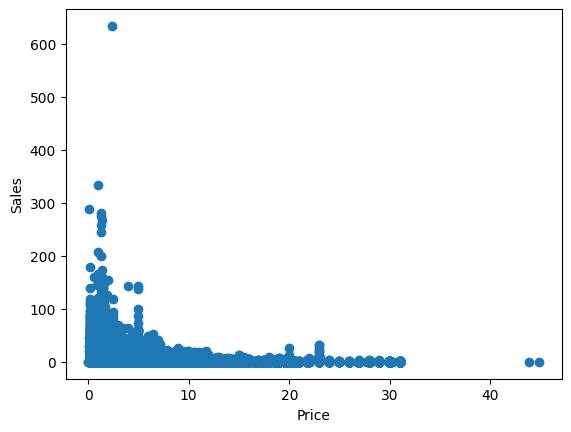

In [38]:
plt.scatter(sampled_df_subset['sell_price'], sampled_df_subset['units_sold'])
plt.xlabel('Price')
plt.ylabel('Sales')
plt.show()

 We see that this is not linear, suggesting that maybe we should divide the items into groups and then regress on price

 # Create time-related features

##### FROM HERE ONWARDS, CHANGE ALL sampled_df to merged_df when running actual model

 Lagged prices up to lag 7:

In [39]:
sampled_df_subset['sell_price_l1'] = sampled_df_subset['sell_price'].shift(1)
sampled_df_subset['sell_price_l2'] = sampled_df_subset['sell_price'].shift(2)
sampled_df_subset['sell_price_l3'] = sampled_df_subset['sell_price'].shift(3)
sampled_df_subset['sell_price_l4'] = sampled_df_subset['sell_price'].shift(4)
sampled_df_subset['sell_price_l5'] = sampled_df_subset['sell_price'].shift(5)
sampled_df_subset['sell_price_l6'] = sampled_df_subset['sell_price'].shift(6)
sampled_df_subset['sell_price_l7'] = sampled_df_subset['sell_price'].shift(7)

### OLS to look at correlation between price + lagged price and items sold

In [52]:
# Regression of units sold on current prices and prices for each of the previous 7 days
price_with_lags = ['sell_price','sell_price_l1', 'sell_price_l2', 'sell_price_l3',
               'sell_price_l4', 'sell_price_l5', 'sell_price_l6',
                 'sell_price_l7']

X = sampled_df_subset[['sell_price','sell_price_l1', 'sell_price_l2', 'sell_price_l3',
               'sell_price_l4', 'sell_price_l5', 'sell_price_l6',
                 'sell_price_l7']].dropna()

y = sampled_df_subset['units_sold'].loc[X.index]

# Fit OLS using statsmodels for p values
X = sm.add_constant(X)
est = sm.OLS(y, X)
est = est.fit()
print(est.summary())

# lr_model = LinearRegression()
# lmfit_units_on_prices = LinearRegression().fit(X, y)

                            OLS Regression Results                            
Dep. Variable:             units_sold   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1335.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:38:21   Log-Likelihood:            -1.3335e+06
No. Observations:              462098   AIC:                         2.667e+06
Df Residuals:                  462089   BIC:                         2.667e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.3118      0.024     95.515

 # Engineering Time-based Features

 Rolling window (mean) for units_sold; i.e. average by windows of 7,28,90 days

In [53]:
# sampled_df_subset['sold_roll_mean_7'] = sampled_df_subset.groupby(['id'])['units_sold'].transform(lambda x: x.shift(1).rolling(7).mean())
# sampled_df_subset['sold_roll_mean_28'] = sampled_df_subset.groupby(['id'])['units_sold'].transform(lambda x: x.shift(1).rolling(28).mean())
# sampled_df_subset['sold_roll_mean_90'] = sampled_df_subset.groupby(['id'])['units_sold'].transform(lambda x: x.shift(1).rolling(90).mean())

 ### Fit LGBM

Using price and lagged price

In [93]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(sampled_df_subset[price_with_lags].dropna(), sampled_df_subset['units_sold'].loc[X.index], test_size = 0.2, random_state = 42)

# LGBM dataset
train_data = lgb.Dataset(X_train, label = y_train, free_raw_data = True)

params = {'objective': 'regression', 'metric': 'rmse'}

In [94]:
# Fit LGBM
lgb_model = lgb.train(params, train_data)

# Test
pred = lgb_model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2016
[LightGBM] [Info] Number of data points in the train set: 369678, number of used features: 8
[LightGBM] [Info] Start training from score 1.436761


In [95]:
print(np.sqrt(mean_squared_error(y_test, pred.round().astype(int))))

4.023298303145826


In [96]:
# Forecast 21 days
next_21_days = sampled_df_subset[price_with_lags].iloc[-21:]

fc = lgb_model.predict(next_21_days).round().astype(int)

print(np.sqrt(mean_squared_error(sampled_df_subset["units_sold"].iloc[-21:], fc)))

2.340126166724879


 ### Fit LGBM

Using more features, including time series info

In [84]:
X_subset = sampled_df_subset[["category_id", "store_id", "region_id", "wday", "month", "year", "day_of_month", "day_of_year", "week_of_month", "week_of_year"] + price_with_lags].dropna()

# Change dtypes
X_subset["category_id"] = X_subset["category_id"].astype("category")
X_subset["store_id"] = X_subset["store_id"].astype("category")
X_subset["region_id"] = X_subset["region_id"].astype("category")

X_subset = pd.get_dummies(X_subset)

X_subset.head()

,wday,month,year,day_of_month,day_of_year,week_of_month,week_of_year,sell_price,sell_price_l1,sell_price_l2,...,store_id_East_1,store_id_East_2,store_id_East_3,store_id_East_4,store_id_West_1,store_id_West_2,store_id_West_3,region_id_Central,region_id_East,region_id_West
7,4,10,2015,6,279,1,40,3.97,1.00,1.00,...,0,0,0,1,0,0,0,0,1,0
8,2,5,2014,25,145,4,21,3.98,3.97,1.00,...,0,0,0,0,0,0,0,1,0,0
9,2,1,2014,5,5,1,1,6.44,3.98,3.97,...,1,0,0,0,0,0,0,0,1,0
10,6,5,2014,29,149,5,21,1.98,6.44,3.98,...,1,0,0,0,0,0,0,0,1,0
11,7,12,2014,12,346,2,49,0.70,1.98,6.44,...,0,0,0,0,0,0,0,1,0,0


In [85]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_subset, sampled_df_subset['units_sold'].loc[X_subset.index], test_size = 0.2, random_state = 42)

# LGBM dataset
train_data = lgb.Dataset(X_train, label = y_train, free_raw_data = True)

params = {'objective': 'regression', 'metric': 'rmse'}

In [86]:
# Fit LGBM
lgb_model = lgb.train(params, train_data)

# Test
pred = lgb_model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 369678, number of used features: 31
[LightGBM] [Info] Start training from score 1.436761


In [92]:
print(np.sqrt(mean_squared_error(y_test, pred.round().astype(int))))

3.8743576301232077


In [91]:
# Forecast 21 days
next_21_days = X_subset.iloc[-21:]

fc = lgb_model.predict(next_21_days).round().astype(int)

print(np.sqrt(mean_squared_error(sampled_df_subset["units_sold"].iloc[-21:], fc)))

2.011869540407391


### Fitting LGBM on each store ID, then predict by store

TODO if have time?

### Fitting LGBM Using only time metrics, on all items and all days (don't run, not worth it)

Results: After rounding off, only produces all 1s for all items and days. So doesn't seem to capture any time based relationship.

Even the 80/20 train test split only produces predictions between 0 and 2.

In [2]:
TRAIN_CSV_PATH = r"../datasets/train.csv"
PRICES_CSV_PATH = r"../datasets/prices.csv"
CAL_CSV_PATH = r"../datasets/calendar.csv"
SAMPLE_CSV_PATH = r"../datasets/sample_submission.csv"

EXPORT_PATH = r"../submissions/"

In [3]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)
df_cal = pd.read_csv(CAL_CSV_PATH)

df_dates = pd.DataFrame(columns = ["d"], data = df_train.columns[6:])
df_dates = df_dates.merge(df_cal[["date", "d"]], on = "d", how = "left")

In [4]:
# Convert to appropriate datatypes
df_train["id"] = df_train["id"].astype("string")
df_train["item_id"] = df_train["item_id"].astype("string")
df_train["subcat_id"] = df_train["subcat_id"].astype("string")
df_train["category_id"] = df_train["category_id"].astype("string")
df_train["store_id"] = df_train["store_id"].astype("string")
df_train["region_id"] = df_train["region_id"].astype("string")

# Change dtypes
df_cal["date"] = pd.to_datetime(df_cal["date"])
df_cal["weekday"] = df_cal["weekday"].astype("string")
df_cal["d"] = df_cal["d"].astype("string")
df_cal["wm_yr_wk"] = df_cal["wm_yr_wk"].astype(int)

# Add column with months in string
month_names_ls = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_int_ls = list(range(1, 13))
month_names_dict = {month_int_ls[i]: month_names_ls[i] for i in range(len(month_int_ls))}

df_cal["month_name"] = df_cal["month"].replace(month_names_dict)

df_dates["d"] = df_dates["d"].astype("string")
df_dates["date"] = pd.to_datetime(df_dates["date"])

In [5]:
dates_dict = dict(zip(list(df_dates["d"]), list(df_dates["date"])))
df_train_dates = df_train.rename(dates_dict, axis = 1)

df_naive_train = df_train_dates[["id"] + list(df_train_dates.columns[6:])].melt(id_vars = ["id"], var_name= "ds", value_name = "y")
df_naive_train = df_naive_train.rename(columns = {"id":"unique_id"})
df_naive_train.head()

,unique_id,ds,y
0,Beauty_1_001_East_1,2011-01-29,0
1,Beauty_1_002_East_1,2011-01-29,0
2,Beauty_1_003_East_1,2011-01-29,0
3,Beauty_1_004_East_1,2011-01-29,0
4,Beauty_1_005_East_1,2011-01-29,0


In [6]:
# Create time based metrics
df_naive_train['day_of_week'] = df_naive_train['ds'].dt.dayofweek + 1
df_naive_train['day_of_month'] = df_naive_train['ds'].dt.day
df_naive_train['day_of_year'] = df_naive_train['ds'].dt.dayofyear
df_naive_train['week_of_month'] = (df_naive_train['ds'].dt.day - 1) // 7 + 1
df_naive_train['month_of_year'] = df_naive_train['ds'].dt.month

In [9]:
df_naive_train['week_of_year'] = pd.to_datetime(df_naive_train['ds']).dt.strftime('%U').astype(int)

In [10]:
df_naive_train.head()

,unique_id,ds,y,day_of_week,day_of_month,day_of_year,week_of_month,month_of_year,week_of_year
0,Beauty_1_001_East_1,2011-01-29,0,6,29,29,5,1,4
1,Beauty_1_002_East_1,2011-01-29,0,6,29,29,5,1,4
2,Beauty_1_003_East_1,2011-01-29,0,6,29,29,5,1,4
3,Beauty_1_004_East_1,2011-01-29,0,6,29,29,5,1,4
4,Beauty_1_005_East_1,2011-01-29,0,6,29,29,5,1,4


In [11]:
x_dummies = pd.get_dummies(df_naive_train[["day_of_week", "day_of_month", "day_of_year", "week_of_month", "month_of_year", "week_of_year"]])
y = df_naive_train["y"]

In [14]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(x_dummies, y, test_size = 0.2, random_state = 42)

# LGBM dataset
train_data = lgb.Dataset(X_train, label = y_train, free_raw_data = True)

params = {'objective': 'regression', 'metric': 'rmse'}

In [15]:
# Fit LGBM
lgb_model = lgb.train(params, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.386323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 46808248, number of used features: 6
[LightGBM] [Info] Start training from score 1.127031


In [16]:
# Test
pred = lgb_model.predict(X_test)

In [17]:
print(np.sqrt(mean_squared_error(y_test, pred.round().astype(int))))

3.8827613711774958


In [43]:
pd.Series(pred.round().astype(int)).describe()

count    1.170206e+07
mean     1.020872e+00
std      1.601037e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.000000e+00
dtype: float64

In [26]:
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)

df_sample_sub.head()

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Beauty_1_002_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Beauty_1_003_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Beauty_1_004_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Beauty_1_005_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
# Create dict to rename columns for submission
sub_dates = pd.date_range(start = "2016-05-01", end = "2016-05-21")
d_to_date = dict(zip(list(df_sample_sub.columns[1:]), list(sub_dates)))
date_to_d = dict(zip(list(sub_dates), list(df_sample_sub.columns[1:])))

In [27]:
df_sample_sub = df_sample_sub.rename(d_to_date, axis = 1)
df_sample_sub = df_sample_sub.melt(id_vars = ["id"], var_name= "ds", value_name = "y")
df_sample_sub = df_sample_sub.rename(columns = {"id":"unique_id"})

# Create time based metrics
df_sample_sub['day_of_week'] = df_sample_sub['ds'].dt.dayofweek + 1
df_sample_sub['day_of_month'] = df_sample_sub['ds'].dt.day
df_sample_sub['day_of_year'] = df_sample_sub['ds'].dt.dayofyear
df_sample_sub['week_of_month'] = (df_sample_sub['ds'].dt.day - 1) // 7 + 1
df_sample_sub['month_of_year'] = df_sample_sub['ds'].dt.month
df_sample_sub['week_of_year'] = pd.to_datetime(df_sample_sub['ds']).dt.strftime('%U').astype(int)

,unique_id,ds,y
0,Beauty_1_001_East_1,2016-05-01,1
1,Beauty_1_002_East_1,2016-05-01,1
2,Beauty_1_003_East_1,2016-05-01,1
3,Beauty_1_004_East_1,2016-05-01,1
4,Beauty_1_005_East_1,2016-05-01,1


In [28]:
df_sample_sub.head()

,unique_id,ds,y,day_of_week,day_of_month,day_of_year,week_of_month,month_of_year,week_of_year
0,Beauty_1_001_East_1,2016-05-01,1,7,1,122,1,5,18
1,Beauty_1_002_East_1,2016-05-01,1,7,1,122,1,5,18
2,Beauty_1_003_East_1,2016-05-01,1,7,1,122,1,5,18
3,Beauty_1_004_East_1,2016-05-01,1,7,1,122,1,5,18
4,Beauty_1_005_East_1,2016-05-01,1,7,1,122,1,5,18


In [30]:
x_forecast = pd.get_dummies(df_sample_sub[["day_of_week", "day_of_month", "day_of_year", "week_of_month", "month_of_year", "week_of_year"]])
pred_forecast = lgb_model.predict(x_forecast)
df_sample_sub["pred"] = pred_forecast.round().astype(int)

In [ ]:
pd.Series(pred_forecast.round().astype(int))

In [34]:
# Pivot back to original df
df_sample_sub = df_sample_sub.drop(["day_of_week", "day_of_month", "day_of_year", "week_of_month", "month_of_year", "week_of_year", "y"], axis = 1)
df_sample_sub.head()

,unique_id,ds,pred
0,Beauty_1_001_East_1,2016-05-01,1
1,Beauty_1_002_East_1,2016-05-01,1
2,Beauty_1_003_East_1,2016-05-01,1
3,Beauty_1_004_East_1,2016-05-01,1
4,Beauty_1_005_East_1,2016-05-01,1


In [36]:
df_sample_sub = df_sample_sub.pivot(index = "unique_id", columns = "ds", values = "pred").reset_index()
df_sample_sub.head()

ds,unique_id,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00,2016-05-06 00:00:00,2016-05-07 00:00:00,2016-05-08 00:00:00,2016-05-09 00:00:00,...,2016-05-12 00:00:00,2016-05-13 00:00:00,2016-05-14 00:00:00,2016-05-15 00:00:00,2016-05-16 00:00:00,2016-05-17 00:00:00,2016-05-18 00:00:00,2016-05-19 00:00:00,2016-05-20 00:00:00,2016-05-21 00:00:00
0,Beauty_1_001_Central_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Beauty_1_001_Central_2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Beauty_1_001_Central_3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Beauty_1_001_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Beauty_1_001_East_2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [37]:
df_sample_sub = df_sample_sub.rename(columns = {"unique_id" : "id"})
df_sample_sub = df_sample_sub.rename(columns = date_to_d)

df_sample_sub.head()

ds,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_Central_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Beauty_1_001_Central_2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Beauty_1_001_Central_3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Beauty_1_001_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Beauty_1_001_East_2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [38]:
# df_sample_sub.to_csv(EXPORT_PATH+"/submission_11.csv", header=True, index=False)